### Introduction

We have deployed our model and it is successfully being used to determine the class of Iris flowers by botanists all over the world!

Enjoying our success and the data science we have been doing, has resulted in us spending more time learning more about LinearSVC models.

One thing we noticed in the [LinearSVC documentation](https://scikit-learn.org/stable/modules/svm.html#svm-classification) was the following:

> Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data.

Oh. What does 'scale your data' mean?


### Scaling Data

There are many ways to scale data (see the [Appendix](#Appendix)).  A good starting point for learning about scalers is StandardScaler:

> Standardize features by removing the mean and scaling to unit variance.
>
> *Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html*

We will try the StandardScaler, below:


In [56]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# We 'fit' the StandardScaler on the training data
std_slc = StandardScaler()
std_slc.fit(X_train)

# We can then use the scaler to transform out training and test datasets
X_train_std = std_slc.transform(X_train)
X_test_std = std_slc.transform(X_test)

Next we can print out the datasets.  We wrap the datasets with pandas dataframes to give us easier to read tables.

In [57]:
import pandas as pd
X_train_df = pd.DataFrame(X_train, columns=["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"])
X_train_std_df = pd.DataFrame(X_train_std, columns=["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"])

Let's look at the first few records of the raw and the standardized dataset

In [40]:
display(X_train_df.head())
display(X_train_std_df.head())

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.0,3.4,1.5,0.2
1,5.2,4.1,1.5,0.1
2,4.6,3.4,1.4,0.3
3,6.0,2.2,4.0,1.0
4,5.8,2.7,5.1,1.9


,Sepal Length,Sepal Width,Petal Length,Petal Width
0,-0.988927,0.760976,-1.214117,-1.242060
1,-0.744446,2.394975,-1.214117,-1.370107
2,-1.477890,0.760976,-1.270378,-1.114012
3,0.233480,-2.040164,0.192413,-0.217681
4,-0.011002,-0.873022,0.811286,0.934746


<AxesSubplot:ylabel='Frequency'>

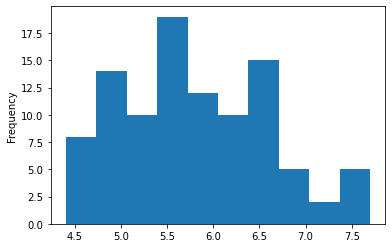

In [55]:
X_train_df['Sepal Length'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

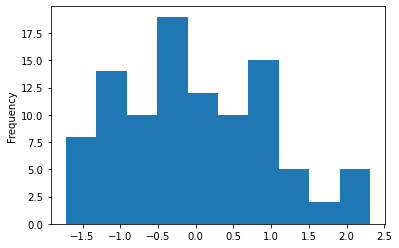

In [53]:
X_train_std_df['Sepal Length'].plot.hist()

### Inconsistent Preprocessing


>  If ... data transforms are used when training a model, they also must be used on subsequent datasets, whether it’s test data or data in a production system. Otherwise, the feature space will change, and the model will not be able to perform effectively.
>
> https://scikit-learn.org/stable/common_pitfalls.html#inconsistent-preprocessing

[TODO] Let's apply this now to our scaled iris model ...



---
### Navigation

[Previous](./11_model_predictions.ipynb) | [Home](./00-README-FIRST.ipynb) | [Next](./98_outro.ipynb) notebook

---

<div class="alert-info">

### Appendix

Other Scikit-learn scalers:

- [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- [sklearn.preprocessing.MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- [sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)
- [sklearn.preprocessing.Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)
- [sklearn.preprocessing.QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html)
- [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)

</div>